### XGBoost

##### Pakete laden

In [3]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score,  mean_squared_error, classification_report, roc_auc_score, roc_curve

import xgboost as xgb
from xgboost import XGBClassifier
import sys

from scipy.stats import uniform, randint

##### *XGBoost* (aus Business Understanding)

Ein weiterer, auf Entscheidungsbäume basierender Lernalgorithmus ist der sogenannte XGBoost (eXtreme Gradient Boosting). XGBoost unterstützt sowohl die Lösung von Klassifikations- als auch Regressionsaufgaben. Ähnlich dem Random Forest Algorithmus wird die Vorhersagegenauigkeit durch Kombination verschiedener Entscheidungsbäume erhöht, allerdings werden diese nicht unabhängig voneinander erstellt. Zur schrittweisen Verbesserung der Modelle auf Basis der Residuen nutzt XGBoost Gradient Boosting. So wird die Verlustfunktion während des Trainingsprozesses optimiert. Der Algorithmus bietet außerdem zahlreiche Hyperparameter zur Verbesserung der Modellleistung. Darunter auch Regularisierungstechniken wie L1- und L2 um Overfitting zu vermeiden und die Modellkompelxität zu kontrollieren. Nebst Anpassungsmöglichkeiten liegen die Stärken von XGBoost vor allem in der Parallelisierung und somit im effizienten Umgang mit großen Datensätze. Obwohl der Algorithmus Mechanismen zur Reduzierung von Overfitting bietet, kann die Vielschichtigkeit des Hyperparameter-Tunings dennoch zu Überanpassung führen. Außerdem ist die Interpretierbarkeit aufgrund der Komplexität eingeschränkt (Chen et al. 2014).



##### Daten für das Training vorbereiten:
1) Merkmale/Features (X) und Zielvariable (y) separieren
2) Die Daten in Trainings- und Testdaten aufteilen. "random_state = 1" sorgt für die Reproduzierbarkeit der Aufteilung
3) Features(sowohl im Train- als auch im Testdaetnsatz) mit dem Datentyp "object" in Datentyp "category" umwandeln. Zielvariable bzw. Labels ebenfalls zunächst als "category" dann in numerische Werte (binär in 0 und 1)
4) Erstellen der DMatrix. DMatrix ist eine spezielle Datenstruktur, die von XGBoost verwendet wird. "enable_categorial=True" ermöglich die Verarbeitung kategorialer Daten

Zunächst wird XGBoost auf dem "unbereinigten" Datensatz ausgeführt (Name: df mit Variablen des Datentyps "object")

In [20]:
# wir verwenden zunächst den unbereinigten Datensatz
df = pd.read_pickle('../HR_Data_raw.pkl')

In [3]:
df.head()

,Attrition,Age,BusinessTravel,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,...,NumCompaniesWorked,OverTime,RelationshipSatisfaction,PerformanceRating,TotalWorkingYears,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,Yes,41,Travel_Rarely,Sales,1,2,2,Female,3,2,...,8,Yes,1,3,8,1,6,4,0,5
1,No,49,Travel_Frequently,Research & Development,8,1,3,Male,2,2,...,1,No,4,4,10,3,10,7,1,7
2,Yes,37,Travel_Rarely,Research & Development,2,2,4,Male,2,1,...,6,Yes,2,3,7,3,0,0,0,0
3,No,33,Travel_Frequently,Research & Development,3,4,4,Female,3,1,...,1,Yes,3,3,8,3,8,7,3,0
4,No,27,Travel_Rarely,Research & Development,2,1,1,Male,3,1,...,9,No,4,3,6,3,2,2,2,2


In [9]:
X = df.drop('Attrition', axis=1) # Zielvariable entfernen
y = df['Attrition']  # 'Attrition' Spalte als Series

# Train-Test-Split durchführen
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15)

# Textfeatures in Kategorien umwandeln
categories = X_train.select_dtypes(include=object).columns.tolist()
for col in categories:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Labels in numerische Codes umwandeln
if y_train.dtype == 'object':
    y_train = y_train.astype('category')
    y_train = y_train.cat.codes

if y_test.dtype == 'object':
    y_test = y_test.astype('category')
    y_test = y_test.cat.codes

# Erstellen der DMatrix
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [5]:
y_test.head()

1122    0
1341    0
1199    0
842     1
789     1
dtype: int8

In [7]:
df.iloc[[1122,1341,1199,842,789]]

,Attrition,Age,BusinessTravel,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,...,NumCompaniesWorked,OverTime,RelationshipSatisfaction,PerformanceRating,TotalWorkingYears,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1122,No,29,Travel_Rarely,Research & Development,3,1,2,Male,3,1,...,1,Yes,4,3,10,3,10,9,1,5
1341,No,31,Travel_Rarely,Research & Development,20,3,2,Male,3,2,...,1,No,1,3,10,3,10,8,0,2
1199,No,36,Travel_Rarely,Research & Development,26,4,1,Male,3,2,...,6,No,2,3,10,2,3,2,0,2
842,Yes,28,Travel_Rarely,Research & Development,12,1,3,Female,3,1,...,1,Yes,4,3,1,2,1,1,0,0
789,Yes,44,Travel_Rarely,Human Resources,1,2,2,Male,2,3,...,9,No,4,3,24,3,20,6,3,6


Zielvariable: Attrition

* Yes (1) --> Mitarbeiter verlässt das Unternehmen
* No (0) --> Mitarbeiter bleibt im Unternehmen

##### Hyperparameter definieren und Modell trainieren:

zur Festlegung der Hyperparameter stehen unterschiedliche Ansätze zur Verfügung. Darunter **Grid Search** (wird später noch behandelt) und **Random Search**. 
- *"objective"*: binäres Klassifikationsproblem mit einer logistischen Regression.
- *"max_depth"*: Maximale Tiefe jedes Entscheidungsbaum. Ein höherer Wert ermöglich komplexere Werte (Achtung: Overfitting).
- *"eta"*: legt die Lernrate fest und steuert die Schrittweite des Gradientabstiegs.Ziel des Gradientenabstiegs ist das Finden der optimalen Werte der Modellparameter zur Minimierung der **Loss Function** (Misst Fehler zwischen vorhergesagten und tatsächlichen Werten, z.B. Mean Squared Error bei linearen Regression oder Log-Loss bei binären Klassifikation). Ein niedriger Werte macht Modell robust ggü. Overfitting (Achtung: mehr Iterationen nötig).
- *"eval_metric"*: Metrik zur Evaluierung des Modells. "logloss" steht für logarithmischer Verlust (Logarithmic Loss) und bewertet wie gut das Klassifikationsmodell Wahrscheinlichkeiten für die Klassen vorhersagt. Beispiel einer "guten" Vorhersage: Tatsächliches Label ist 1 und Modell sagt Wahrscheinlichkeit von 0,9 vorher. Dann ist Log Loss relativ klein. Hier wird "logloss" als Evaluationsmetrik verwendet um Leistung des Modells während des Trainings zu bewerten (Ziel: Minimierung des logarithmischen Verlustes).
- *"xgb.train"*: Trainiert das XGBoost Modell mit oben definierten Parametern und den Trainingsdaten.
- *"num_boost_round"*: Anzahl der Boosting-Runden. Jede Boosting-Runde (sequenzielles Training) fügt neuen Entscheidungsbaum hinzu und korrigiert die Fehler (Residuen) des vorherigen Baumes. Idee: Kombination vieler schwacher Modelle ergibt starkes Lernmodell.

In [10]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.1,
    'eval_metric': 'logloss'
}
model = xgb.train(params, dtrain_reg, num_boost_round=100)

In [9]:
y_train

296     1
1007    1
15      0
58      0
36      1
       ..
1223    1
667     1
156     0
384     0
645     1
Length: 1102, dtype: int8

##### Vorhersagen und Genauigkeit

Hier wird ein Schwellenwert von 0,5 verwendet. D.h. wenn vorhergesagte Wahrscheinlichkeit größer 0,5 ist, wird Vorhersage als 1, also positive Klasse (hier: "Mitarbeiter verlässt Unternehmen") klassifiziert, ansonsten als 0 (hier: "Mitarbeiter bleibt im Unternehmen").

- *accuracy* gibt Genauigkeit des Modells zurück und vergleicht tatsächliche Labels ("*y_test*") mit den vorhergesagten Labels ("*y_pred*").
- *(r)mse* stellt die durchschnittliche (Quadratwurzel der) quadratische Differenz ((root) mean square error)  zwischen tatsächlichem und vorhergesagtem Wert dar. 
- *auc* ist das Maß für die Fähigkeit eines binären Klassifikationsmodells, zwischen positiven und negativen Klassen zu unterscheiden (Area Unter the Curve). 


In [11]:
# Vorhersagen
y_pred_prob = model.predict(dtest_reg)
y_pred = (y_pred_prob > 0.5).astype(int)


# Genauigkeit berechnen
accuracy = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred_prob)
rmse = np.sqrt(mse)
auc = roc_auc_score(y_test, y_pred_prob) 
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

print(f"Accuracy: {accuracy}")
print(f"mse: {mse}")
print(f"rmse: {rmse}")
print(f"Area under Curve: {auc}")

Accuracy: 0.8777173913043478
mse: 0.0987119431467234
rmse: 0.31418456860056543
Area under Curve: 0.7674569473932531


##### Classification Report

- *precision-score* gibt an, wie das Verhältnis zwischen wahr-positiven Vorhersagen und der Gesamtzahl der positiven Vorhersagen ist. 
- *recall-score* misst die Fähigkeit, alle positiven Fälle zu finden (Verhältnis positiver Vorhersagen zu tatsächlich positive Werten)
- *F1 score* harmonischer Mittelwert von precision- und recall-score

In [12]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Metriken mit mehr Nackommastellen
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       314
           1       0.66      0.35      0.46        54

    accuracy                           0.88       368
   macro avg       0.78      0.66      0.69       368
weighted avg       0.86      0.88      0.86       368

Precision: 0.6551724137931034
Recall: 0.35185185185185186
F1 Score: 0.4578313253012048


### Visualisierungen

##### 1. Visualisierung der Vorhersagegenauigkeit mittels Confusion Matrix

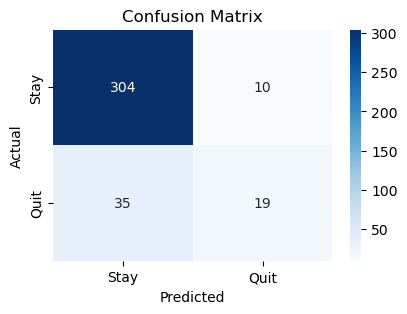

In [13]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4.5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Stay', 'Quit'], yticklabels=['Stay', 'Quit'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

##### Visualisierung der Feature Importance

Der Feature importance plot berechnet, wie häufig das Feature verwendet wurde, um Entscheidungsbäume im Modell aufzuteilen.

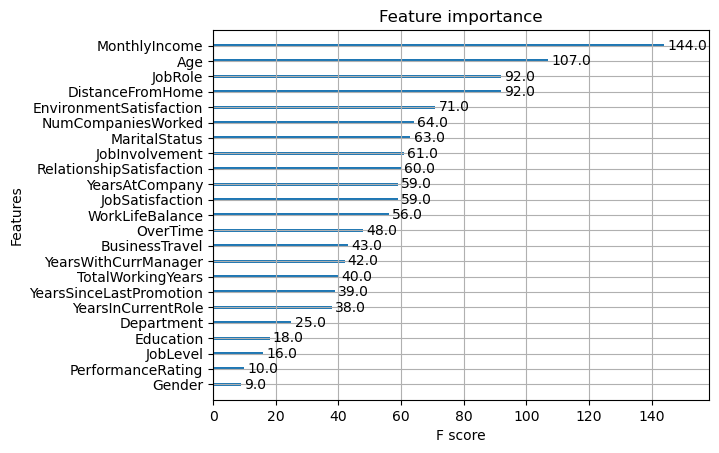

In [14]:
xgb.plot_importance(model, importance_type="weight")
plt.show()

##### Visualisierung anhand eines Entscheidungsbaums

Um die Entscheidungsregeln und die Struktur der Bäume besser zu verstehen, kann man sich diese grafisch darstellen lassen. 

In [15]:
# 1. Graphiz installieren und zum Path hinzufügen
# pip install graphviz

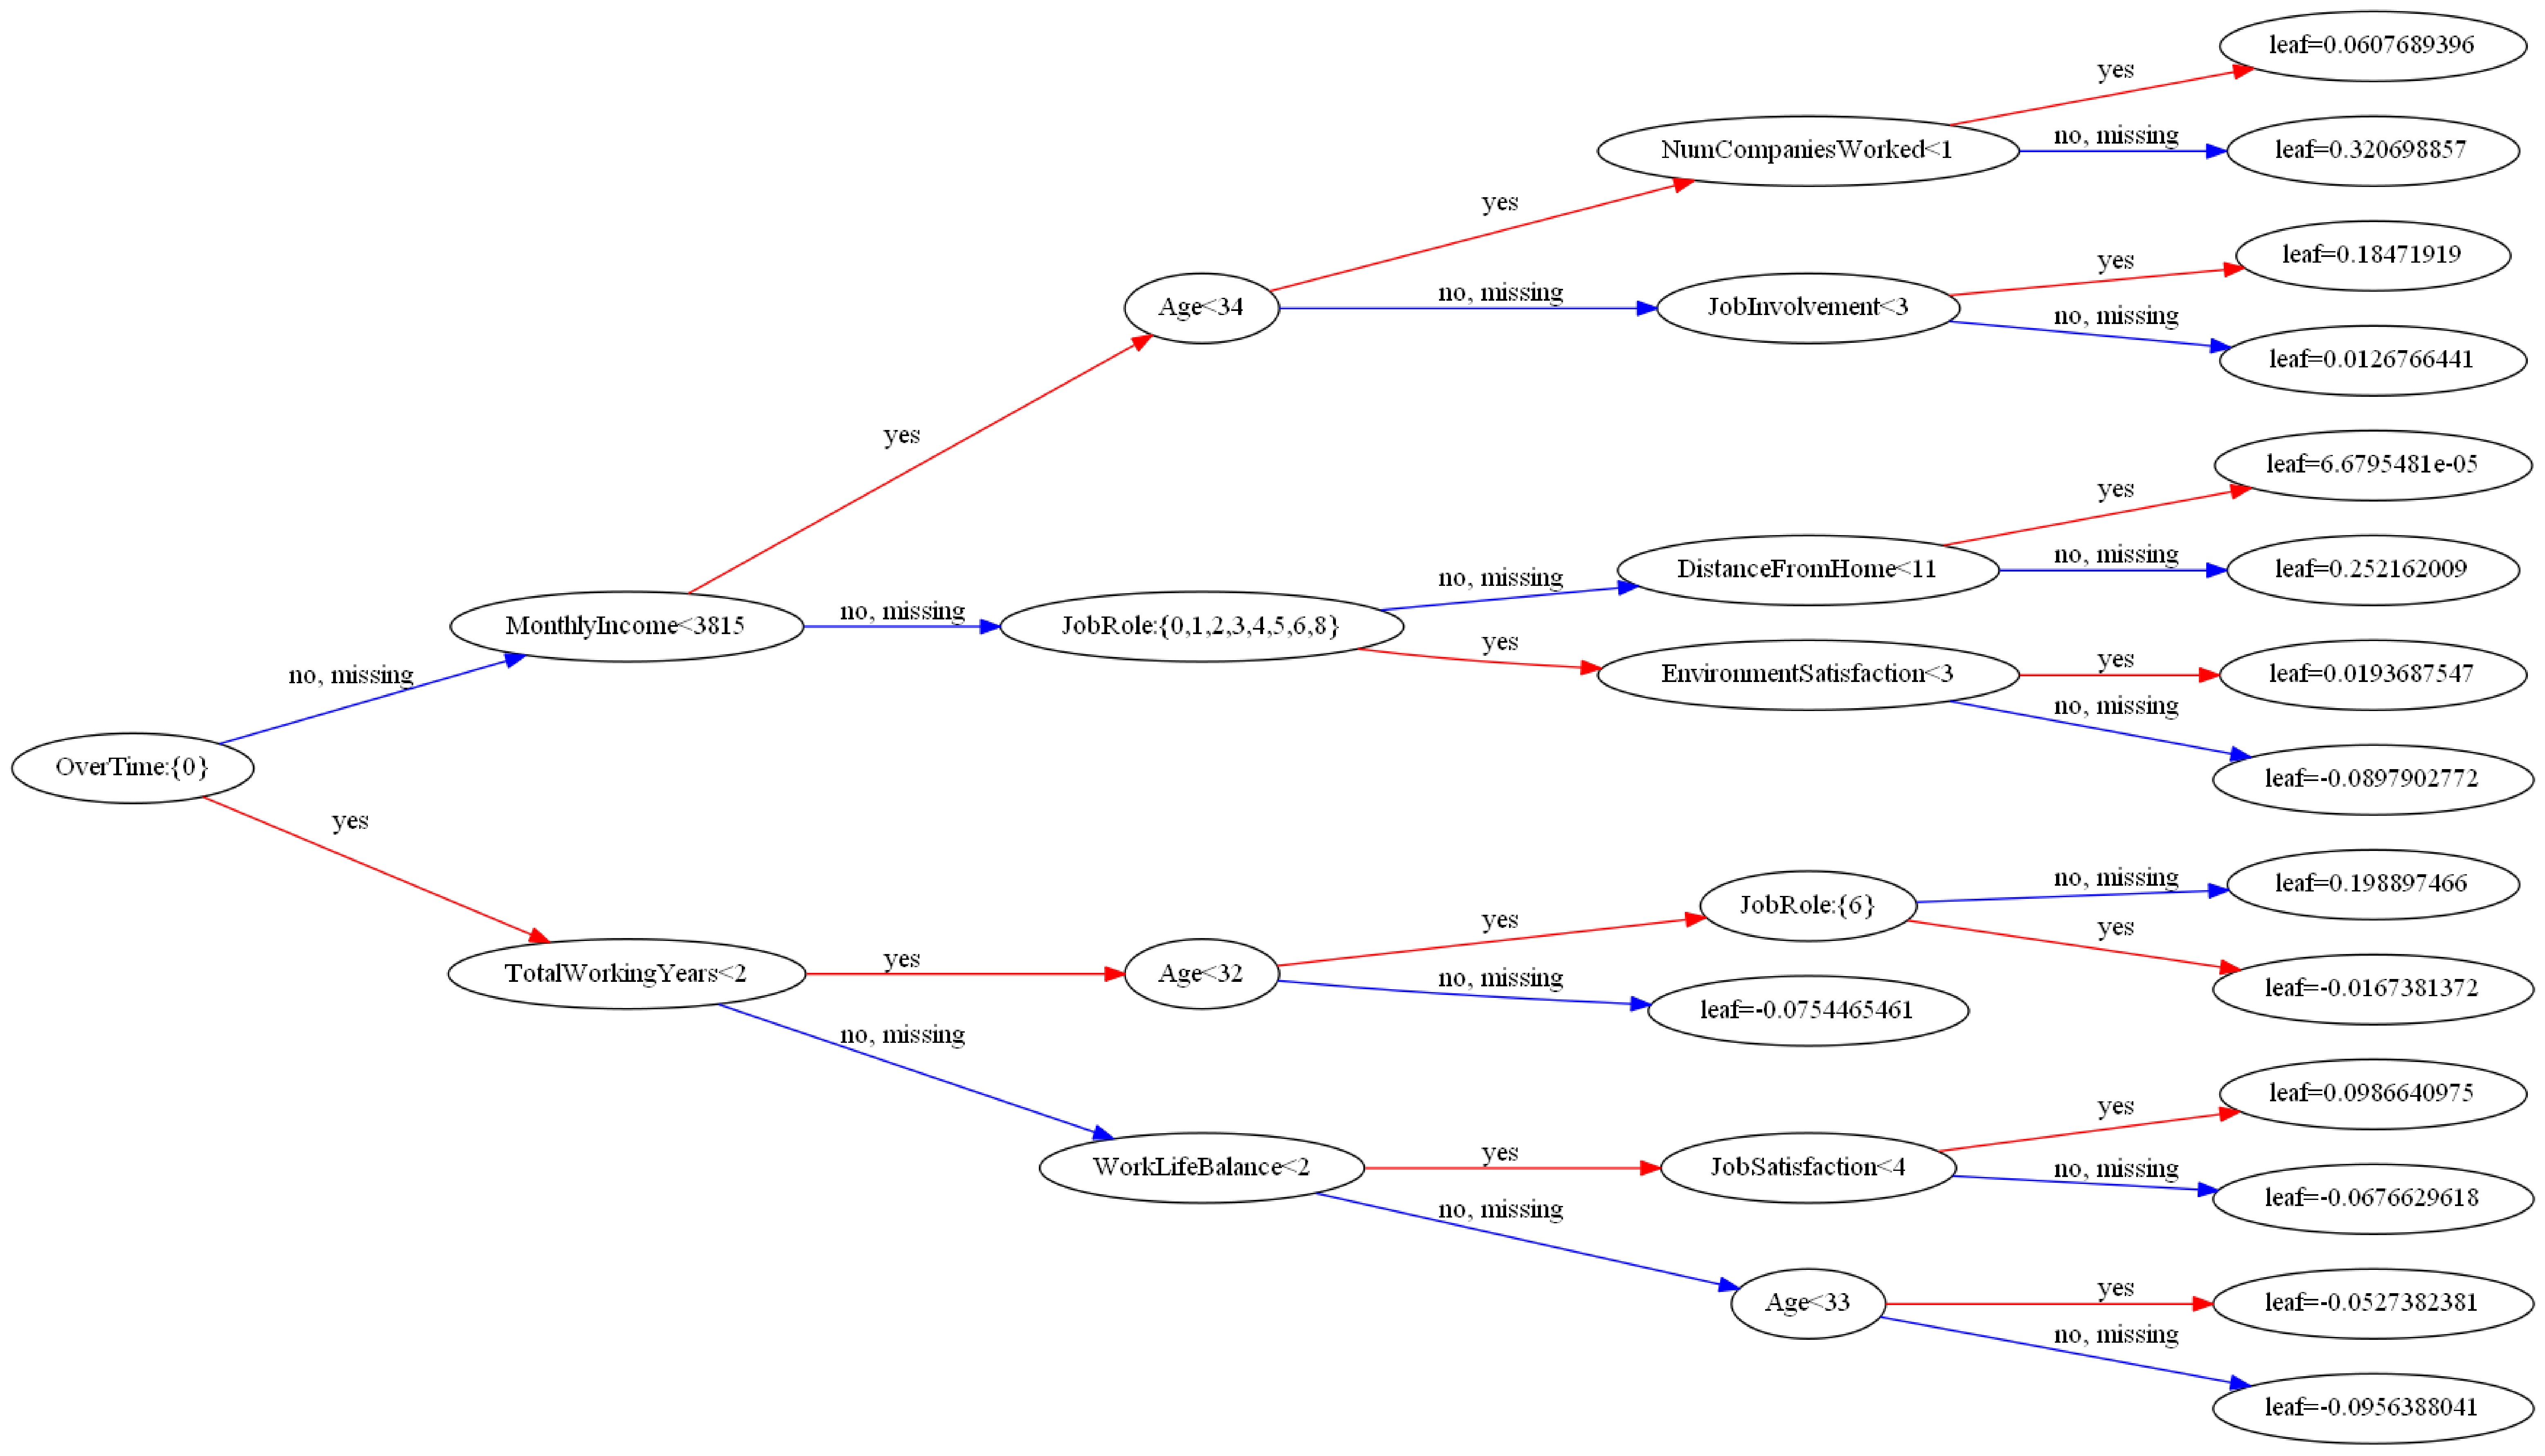

In [16]:
# plot des Entscheidungsbaumes
fig, ax = plt.subplots(figsize=(80, 50)) 
xgb.plot_tree(model, num_trees=0, rankdir = 'LR',  ax=ax)
plt.show()

Die erste Entscheidung in diesem Fall bezieht sich auf die Variable "Overtime" (0 bzw. "No"?), wird diese Frage mit Ja beantwortet, wird die Variable "TotalWorkingYears" (kleiner als 2?) geprüft. 
Die Fragen werden durchlaufen, bis die Blätter erreicht werden. Die Blattwerte geben dabei den Logarithmus der Wahrscheinlichkeit an, dass das Ergebnis "Attrition" = Yes ist, d.h. die Wahrscheinlichkeit, dass der Mitarbeiter das Unternehmen verlässt. 

Ein Mitarbeiter im untersten Blatt erfüllt demzufolge die folgenden Kriterien:
* Overtime = No
* TotalWorkingYears ≥ 2
* WorkLifeBalance ≥ 2 (gute bis sehr gute Work-Life Balance)
* Age ≥ 33

Die Wahrscheinlichkeit, dass ein Mitarbeiter im untersten Blatt das Unternehmen verlässt wird auf etwa 47,61 % geschätzt.

In [17]:
# Beispielberechnung der Wahrscheinlichkeit (log-odds), dass ein Mitarbeiter im untersten Blatt das Unternehmen verlässt,
# wird auf folgenden Wert geschätzt: 
1/(1+ np.exp(-(-0.0956388041))) 

0.4761085070536057

In unserem Beispiel wurden bis hierhin kategoriale Werte mit xgb.train verwendet. 
Um einige scikit-learn tools anzuwenden, muss jedoch xgb.Classifier angewandt werden. Dafür müssen die kategorialen Werte in numerische Form kodiert werden. Eine Möglichkeit das zu tun ist One-Hot-Encoding, welches für jede Merkmalsausprägung eine eigene Spalte erzeugt, welche True oder False sein kann.

Hierfür wird der Datensatz "HR_Data_One_Hot_Encoded.pkl" aus der Data Prepartion verwendet.

In [21]:
# Laden des One-Hot-Encoded Datensatzes aus der Data Preparation
one_hot_encoded_df = pd.read_pickle('../HR_Data_One_Hot_Encoded.pkl')

In [22]:
# One hot encoding
# s. Data Preparation
# Splitten in Features (X) und Zielvariable (y)
X = one_hot_encoded_df.drop(columns=['Attrition_No', 'Attrition_Yes']) # Zielvariable entfernen

df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0}) # Zielvariable in 0 und 1 mappen
y = df['Attrition'] # Zielvariable aus unbereinigtem Datensatz


# Aufteilen in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Erstellen und Trainieren des XGBoost-Modells mit XGBClassifier
xgb_model = XGBClassifier(objective='binary:logistic', max_depth=4, learning_rate=0.1, n_estimators=100, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Vorhersagen mit dem Modell
xgb_preds = xgb_model.predict(X_test)
xgb_y_pred = (xgb_preds > 0.5).astype(int)

one_hot_encoded_df.head()

,Age,DistanceFromHome,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1,2,2,3,2,4,5993,8,1,...,False,False,False,True,False,False,False,True,False,True
1,49,8,1,3,2,2,2,5130,1,4,...,False,False,True,False,False,False,True,False,True,False
2,37,2,2,4,2,1,3,2090,6,2,...,False,False,False,False,False,False,False,True,False,True
3,33,3,4,4,3,1,3,2909,1,3,...,False,False,True,False,False,False,True,False,False,True
4,27,2,1,1,3,1,2,3468,9,4,...,False,False,False,False,False,False,True,False,True,False


### Kreuzvalidierung

Mit Kreuzvalidierung kann geprüft werden, wie gut ein Modell auf neue Daten angewendet werden kann. Dafür wird das Modell k-mal trainiert mit unterschiedlich großen Teilmengen. Die Modelleistung wird für jeden Durchlauf gemessen und ein Durchschnitt berechnet.

In [23]:
# Kreuzvalidierung
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cross_val_results = cross_val_score(xgb.XGBClassifier(**params), X, y, cv=kfold, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cross_val_results.mean()} +/- {cross_val_results.std()}")

Cross-Validation Accuracy: 0.8741496598639455 +/- 0.007134754069184712


### Erklärung der Vorhersagen mittels SHAP

SHapley Additive exPlanations (SHAP) ist eine Methode zur Erklärung der Vorhersagen von Machine-Learning-Modellen. In XGBoost wird SHAP verwendet, um die Beitrage einzelner Merkmale zu den Modellvorhersagen zu quantifizieren und zu visualisieren. 

SHAP-Werte quantifizieren den Einfluss jedes Merkmals auf die Modellvorhersage.
Mit SHAP können verschiedene Plots erstellt werden, um die Bedeutung und den Einfluss der Merkmale zu visualisieren.

- Im *Summary Plot* sind die Merkmale nach Bedeutung sortiert. Die X-Achse zeigt den Einfluss des Merkmals auf die Vorhersage. 
Postive Werte bedeuten, dass das Merkmal die Wahrscheinlichkeit erhöht, dass das Modell eine positive Klasse vorhersagt. Negative Werte bedeuten, dass das Merkmal diese Wahrscheinlichkeit verringert. 
Die Farbe repräsentiert den Wert des Merkmales (rot hohe Werte, blau niedrige Werte)

- Ein *Dependence Plot* zeigt die Beziehung zwischen den SHAP-Werten eines bestimmten Merkmals und den Werten dieses Merkmals selbst.

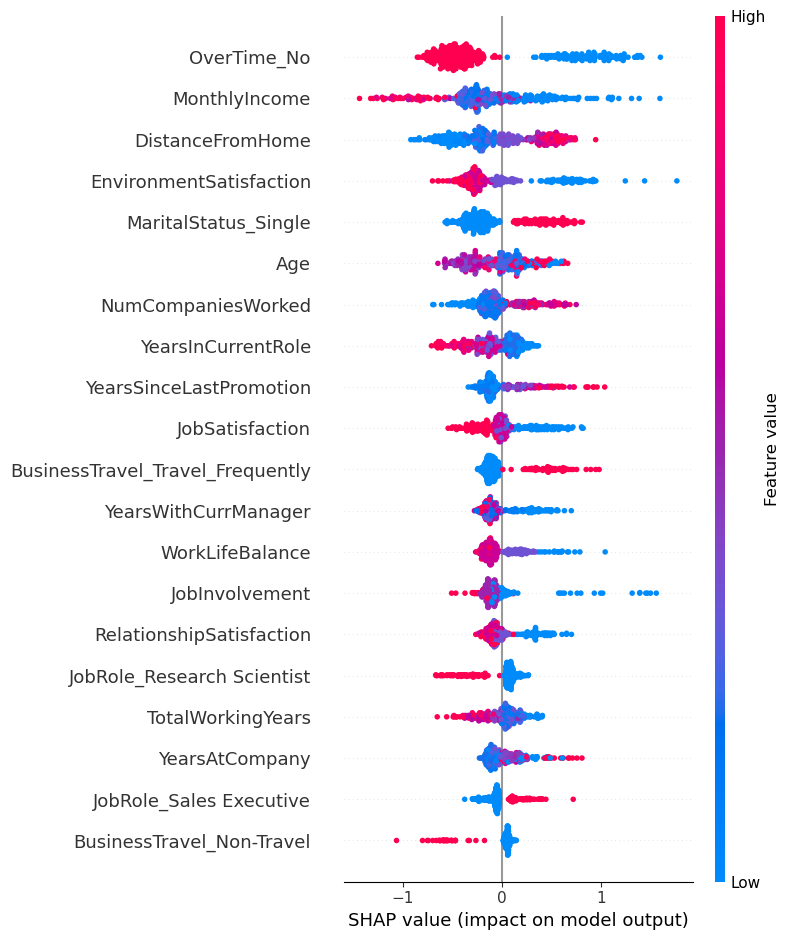

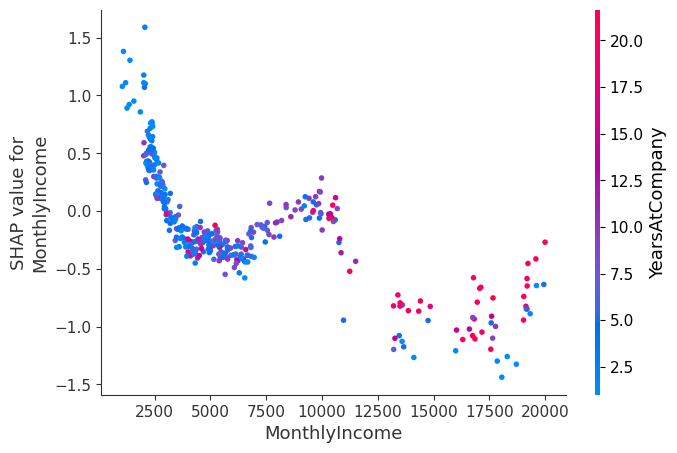

In [25]:
# Erstellung SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test)

# Dependence plot für das Merkmal "Monthly Income"
shap.dependence_plot('MonthlyIncome', shap_values, X_test)

### Hyperparameter Tuning

Mit Hilfe von GridSearchCV kann aus einer Auswahl von Parametern die ideale Kombination ermittelt werden. 
Durch Verwendung von RandomSearchCV kann durch die Festlegung von Iterationen eine zufällig ideale Parameterkombination ermittelt werden.

- *max_depth:* Steuert, wie tief jeder einzelne Entscheidungsbaum wachsen kann. Größere Werte können zu komplexeren Modellen führen.
- *learning_rate (eta):* Kleinere Werte machen das Training langsamer, aber stabiler. Ein niedrigerer Wert erfordert oft mehr n_estimators.
- *n_estimators:* Gibt an, wie viele Bäume im Modell trainiert werden. Mehr Bäume können zu besseren Modellen führen, aber auch die Rechenzeit erhöhen.
- *subsample:* Der Anteil der Trainingsdaten, die für jede Boosting-Runde zufällig ausgewählt werden. Reduziert Overfitting, Werte zwischen 0.5 und 1.0 sind üblich.
- *colsample_bytree:* Der Anteil der Merkmale, die für das Training jedes Baumes zufällig ausgewählt werden. Reduziert Overfitting, indem es die Vielfalt der Bäume erhöht. Werte zwischen 0.5 und 1.0 sind üblich.
- *reg_alpha (alpha):* L1-Regularisierungsterm, der eine Strafe für die Summe der absoluten Werte der Koeffizienten hinzufügt. Fördert Sparsamkeit im Modell, indem es einige Koeffizienten auf genau Null setzt, was effektiv einer Feature-Auswahl entspricht und Overfitting reduziert.
- *reg_lambda (lambda):* L2-Regularisierungsterm, der eine Strafe für die Summe der Quadrate der Koeffizienten hinzufügt. Stabilisiert das Modell, indem es alle Koeffizienten schrumpft, um Überanpassung zu reduzieren, ohne sie auf Null zu setzen, was zu einem glatteren und weniger komplexen Modell führt.
- *gamma:* Mindesteste Verlustreduktion, die erforderlich ist, um eine Baumaufspaltung durchzuführen. Höhere Werte führen dazu, dass weniger Splits durchgeführt werden, was zu einfacheren und weniger overfitted Modellen führt.

In [31]:
# Grid Search: Definiere Parameter, je mehr Parameter betrachtet werden sollen, desto länger dauert die Suche 
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.2, 0.5],
    'n_estimators': [25, 50, 75],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree':[0.3, 0.5, 0.7, 1.0], 
    #'reg_alpha': [0, 0.01, 0.1, 1],
    #'reg_lambda': [0, 0.01, 0.1, 1],
    # 'gamma': [0, 0.1, 0.5, 1]

}

# Grid Search durchführen
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)


print(f"Best Parameter: {grid_search.best_params_}, BEst Score: {grid_search.best_score_}")

Best Parameter: {'colsample_bytree': 0.3, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}, BEst Score: 0.8774952612249733


In [27]:
# Random Search: Definiere Parametergrenzen
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.1),
    'colsample_bytree': uniform(0.6, 0.1),
    'reg_alpha': uniform(0, 0.1),
    'reg_lambda': uniform(0, 0.1)
}

# RandomizedSearchCV starten, n_iter gibt an, wieviele Iterationen durchgeführt werden
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=1,
    n_jobs=-1
)

# Fit
random_search.fit(X_train, y_train)

print(f"Best Parameter: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameter: {'colsample_bytree': 0.6800632672680617, 'learning_rate': 0.07989228215230612, 'max_depth': 4, 'n_estimators': 180, 'reg_alpha': 0.03878606440641718, 'reg_lambda': 0.08635418545594287, 'subsample': 0.6747121642737184}
Best Score: 0.8756811989100818


### Visualisierung Modellperformance

Die *ROC-Curve* (Receiver Operating Characteristic) ist ein Tool zur Bewertung der Leistung eines binären Klassifikationsmodells. Sie stellt die wahre positive Rate (True Positive Rate, TPR) gegenüber der falschen positiven Rate (False Positive Rate, FPR) dar, um die Trennschärfe des Modells bei verschiedenen Schwellenwerten zu visualisieren

In [28]:
model_after_tuning = XGBClassifier(objective='binary:logistic', colsample_bytree = 0.6800632672680617, learning_rate = 0.07989228215230612, max_depth= 4, n_estimators= 180, reg_alpha= 0.03878606440641718, reg_lambda= 0.08635418545594287, subsample= 0.6747121642737184, eval_metric='logloss')
model_after_tuning.fit(X_train, y_train)

xgb_preds_after = model_after_tuning.predict(X_test)
xgb_y_pred_after = (xgb_preds_after > 0.5).astype(int)

# Berechnen der FPR, TPR und AUC nach dem Tuning
fpr_after, tpr_after, _ = roc_curve(y_test, xgb_preds_after)
roc_auc_after = roc_auc_score(y_test, xgb_preds_after)

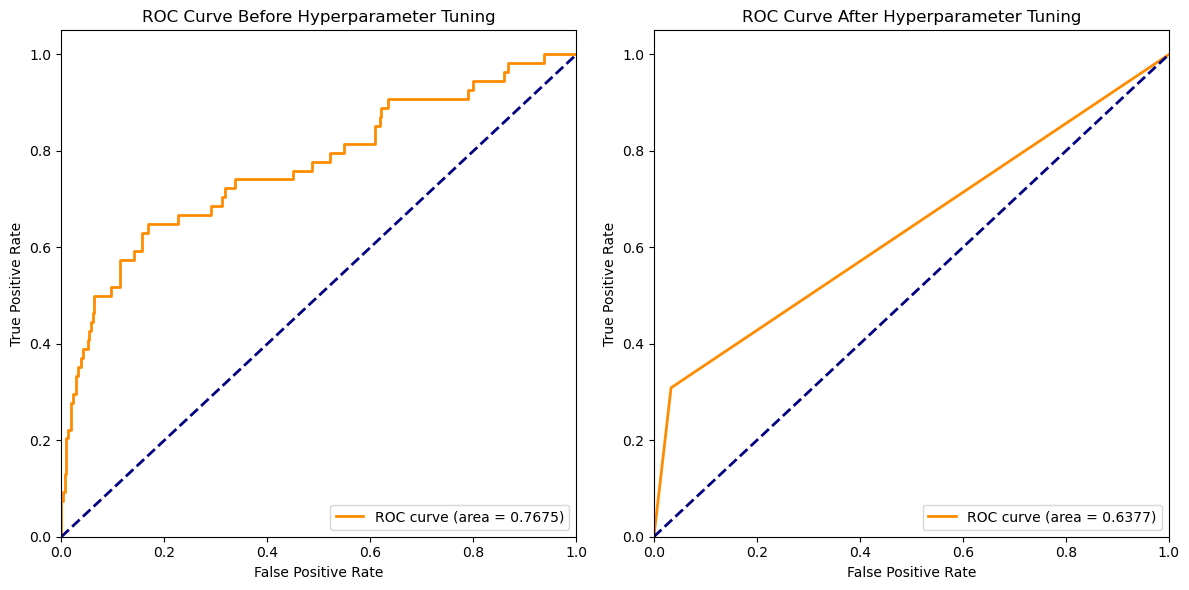

In [29]:
# Plotten der ROC-Kurven vor und nach dem Tuning
plt.figure(figsize=(12, 6))

# ROC-Kurve vor dem Tuning
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Before Hyperparameter Tuning')
plt.legend(loc="lower right")

# ROC-Kurve nach dem Tuning
plt.subplot(1, 2, 2)
plt.plot(fpr_after, tpr_after, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_after:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve After Hyperparameter Tuning')
plt.legend(loc="lower right")

plt.tight_layout()

Die Genauigkeit des Modells wird durch den vorherigen Grid Search bzw. Random Search nicht verbessert.

Wie im Data Understanding bereits festgestellt wurde, ist die Zielvariable "Attrition" unausgeglichen ist. 1.233 (84%) Mitarbeitende haben das Unternehmen nicht verlassen, während nur 237 (16%) gegangen sind. XGBoost hat einen speziellen Parameter scale_pos_weight für unausgeglichene Klassen.

https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

The scale_pos_weight value is used to scale the gradient for the positive class.

This has the effect of scaling errors made by the model during training on the positive class and encourages the model to over-correct them. In turn, this can help the model achieve better performance when making predictions on the positive class. Pushed too far, it may result in the model overfitting the positive class at the cost of worse performance on the negative class or both classes.

As such, the scale_pos_weight can be used to train a class-weighted or cost-sensitive version of XGBoost for imbalanced classification.

A sensible default value to set for the scale_pos_weight hyperparameter is the inverse of the class distribution. For example, for a dataset with a 1 to 100 ratio for examples in the minority to majority classes, the scale_pos_weight can be set to 100. This will give classification errors made by the model on the minority class (positive class) 100 times more impact, and in turn, 100 times more correction than errors made on the majority class.

Daher wird der Grid Search noch einmal mit diesem Parameter ausgeführt

In [34]:
# Random Search: Definiere Parametergrenzen
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.1),
    'colsample_bytree': uniform(0.6, 0.1),
    'reg_alpha': uniform(0, 0.1),
    'reg_lambda': uniform(0, 0.1),
    'scale_pos_weight': uniform(1, 10)
}

# RandomizedSearchCV starten, n_iter gibt an, wieviele Iterationen durchgeführt werden
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=1,
    n_jobs=-1
)

# Fit
random_search.fit(X_train, y_train)

print(f"Best Parameter: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameter: {'colsample_bytree': 0.6963262528440711, 'learning_rate': 0.06218670000413931, 'max_depth': 8, 'n_estimators': 93, 'reg_alpha': 0.06931851990942818, 'reg_lambda': 0.0012712665062582507, 'scale_pos_weight': 5.595452841220066, 'subsample': 0.6961317262255515}
Best Score: 0.8720555423922917


In [ ]:
model_after_tuning = XGBClassifier(objective='binary:logistic', colsample_bytree = 0.6800632672680617, learning_rate = 0.07989228215230612, max_depth= 4, n_estimators= 180, reg_alpha= 0.03878606440641718, reg_lambda= 0.08635418545594287, subsample= 0.6747121642737184, eval_metric='logloss')
model_after_tuning.fit(X_train, y_train)

xgb_preds_after = model_after_tuning.predict(X_test)
xgb_y_pred_after = (xgb_preds_after > 0.5).astype(int)

# Berechnen der FPR, TPR und AUC nach dem Tuning
fpr_after, tpr_after, _ = roc_curve(y_test, xgb_preds_after)
roc_auc_after = roc_auc_score(y_test, xgb_preds_after)